# MRPC Data classification model

## Setup and Import all pre requisite

In [1]:
!pip install --upgrade matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 KB 33.3 MB/s eta 0:00:00


In [2]:
!pip install ktrain --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 61.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 69.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.4/265.4 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 44.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()
from collections import Counter
import csv
import ktrain
from ktrain import text


## EDA

In [51]:
TRAIN = '/content/msr_paraphrase_train.txt'
TEST = '/content/msr_paraphrase_test.txt'
train_df = pd.read_csv(TRAIN, delimiter='\t', quoting=csv.QUOTE_NONE)
test_df = pd.read_csv(TEST, delimiter='\t', quoting=csv.QUOTE_NONE)

In [5]:
train_df.head()

Quality    #1 ID    #2 ID  \
0        1   702876   702977   
1        0  2108705  2108831   
2        1  1330381  1330521   
3        0  3344667  3344648   
4        1  1236820  1236712   

                                           #1 String  \
0  Amrozi accused his brother , whom he called " ...   
1  Yucaipa owned Dominick 's before selling the c...   
2  They had published an advertisement on the Int...   
3  Around 0335 GMT , Tab shares were up 19 cents ...   
4  The stock rose $ 2.11 , or about 11 percent , ...   

                                           #2 String  
0  Referring to him as only " the witness " , Amr...  
1  Yucaipa bought Dominick 's in 1995 for $ 693 m...  
2  On June 10 , the ship 's owners had published ...  
3  Tab shares jumped 20 cents , or 4.6 % , to set...  
4  PG & E Corp. shares jumped $ 1.63 or 8 percent...

In [6]:
test_df.head()

Quality    #1 ID    #2 ID  \
0        1  1089874  1089925   
1        1  3019446  3019327   
2        1  1945605  1945824   
3        0  1430402  1430329   
4        0  3354381  3354396   

                                           #1 String  \
0  PCCW 's chief operating officer , Mike Butcher...   
1  The world 's two largest automakers said their...   
2  According to the federal Centers for Disease C...   
3  A tropical storm rapidly developed in the Gulf...   
4  The company didn 't detail the costs of the re...   

                                           #2 String  
0  Current Chief Operating Officer Mike Butcher a...  
1  Domestic sales at both GM and No. 2 Ford Motor...  
2  The Centers for Disease Control and Prevention...  
3  A tropical storm rapidly developed in the Gulf...  
4  But company officials expect the costs of the ...

In [7]:
Counter(train_df['Quality'])

Counter({1: 2753, 0: 1323})

In [8]:
print('Total number of sentence pairs for training: {}'.format(len(train_df)))
print('Duplicate pairs: {}%'.format(round(train_df['Quality'].mean()*100, 2)))
sids = pd.Series(train_df['#1 ID'].tolist() + train_df['#2 ID'].tolist())
print('Total number of sentences in the training data: {}'.format(len(np.unique(sids))))
print('Number of sentences that appear multiple times: {}'.format(np.sum(sids.value_counts() > 1)))

Total number of sentence pairs for training: 4076
Duplicate pairs: 67.54%
Total number of sentences in the training data: 7817
Number of sentences that appear multiple times: 308


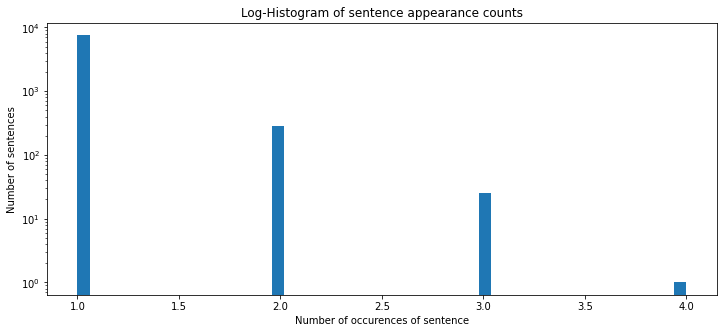

In [9]:
plt.figure(figsize=(12, 5))
plt.hist(sids.value_counts(), bins=50)
plt.yscale('log')
plt.title('Log-Histogram of sentence appearance counts')
plt.xlabel('Number of occurences of sentence')
plt.ylabel('Number of sentences')
print()

### Sentence occurance:
We can see that, most sentences occur only once, but there are a few sentences that occur more than once.

mean-train 118.73 std-train 33.37 mean-test 118.20 std-test 33.49 max-train 226.00 max-test 222.00


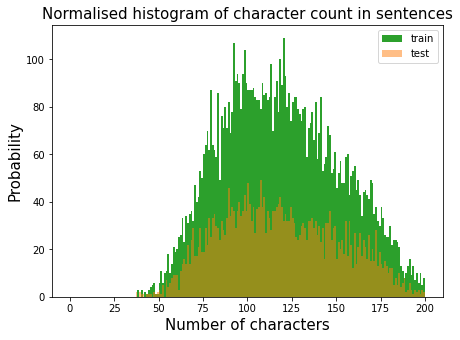

In [10]:
train_s = pd.Series(train_df['#1 String'].tolist() + train_df['#2 String'].tolist()).astype(str)
test_s = pd.Series(test_df['#1 String'].tolist() + test_df['#2 String'].tolist()).astype(str)

dist_train = train_s.apply(len)
dist_test = test_s.apply(len)
plt.figure(figsize=(7, 5))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], alpha=0.5, label='test')
plt.title('Normalised histogram of character count in sentences', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

### Character count:
With this viualization we can say that most of the character per sentence is high only few sentence has less then 50 character.

mean-train 21.95 std-train 5.65 mean-test 21.75 std-test 5.66 max-train 42.00 max-test 36.00


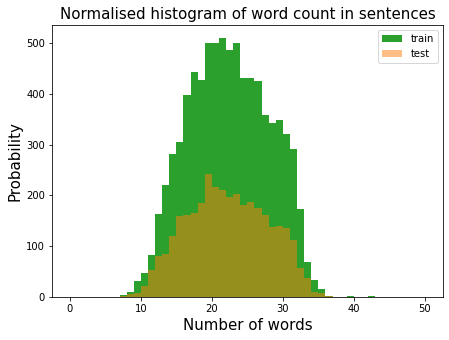

In [11]:
dist_train = train_s.apply(lambda x: len(x.split(' ')))
dist_test = test_s.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(7, 5))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], alpha=0.5, label='test')
plt.title('Normalised histogram of word count in sentences', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

### Word count:
We can visualize similar trends here like above in number of words. Good thing is both train and test sets are even in length of sentences.

# Data Preparation for training

In [57]:
# test_df = pd.read_csv(TEST, delimiter='\t', quoting=csv.QUOTE_NONE)
# from sklearn.model_selection import train_test_split
x_train = train_df[['#1 String', '#2 String']].values
y_train = train_df['Quality'].values
# x_train, x_test, y_train, y_test = train_test_split(X,y ,
#                                    random_state=104, 
#                                    test_size=0.25, 
#                                    shuffle=True)
x_test = test_df[['#1 String', '#2 String']].values
y_test = test_df['Quality'].values

In [58]:
# IMPORTANT: data format for sentence pair classification is list of tuples of form (str, str)
x_train = list(map(tuple, x_train))
x_test = list(map(tuple, x_test))
print(x_train[0])
print(y_train[0])

('Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .')
1


# Model training

In [59]:
MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=128, class_names=['not paraphrase', 'paraphrase'])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, batch_size=32) # lower bs if OOM occurs
learner.fit_onecycle(5e-5, 5)

preprocessing train...
language: en
sentence pairs detected


Is Multi-Label? False
preprocessing test...
language: en
sentence pairs detected




begin training using onecycle policy with max lr of 5e-05...
Epoch 1/5
128/128 [==============================] - 121s 803ms/step - loss: 0.6029 - accuracy: 0.6855
Epoch 2/5
128/128 [==============================] - 102s 796ms/step - loss: 0.4240 - accuracy: 0.8067
Epoch 3/5
128/128 [==============================] - 102s 796ms/step - loss: 0.2765 - accuracy: 0.8933
Epoch 4/5
128/128 [==============================] - 102s 797ms/step - loss: 0.1192 - accuracy: 0.9612
Epoch 5/5
128/128 [==============================] - 102s 800ms/step - loss: 0.0464 - accuracy: 0.9882


# Validation

In [60]:
learner.validate(val_data=val, class_names=['not paraphrase', 'paraphrase'])

1725/1725 [==============================] - 65s 35ms/step
                precision    recall  f1-score   support

not paraphrase       0.81      0.63      0.71       578
    paraphrase       0.83      0.93      0.88      1147

      accuracy                           0.83      1725
     macro avg       0.82      0.78      0.80      1725
  weighted avg       0.83      0.83      0.82      1725



array([[ 367,  211],
       [  84, 1063]])

# Model Save


In [61]:
predictor = ktrain.get_predictor(learner.model, t)

In [62]:
predictor.save('mrpc_model')

# Prediction

In [63]:
y_test[:5]

array([1, 1, 1, 0, 0])

In [64]:
positive_sen = x_test[0]
negative_sen = x_test[4]

In [65]:
print('Valid Paraphrase:\n%s' %(positive_sen,))

Valid Paraphrase:
("PCCW 's chief operating officer , Mike Butcher , and Alex Arena , the chief financial officer , will report directly to Mr So .", 'Current Chief Operating Officer Mike Butcher and Group Chief Financial Officer Alex Arena will report to So .')


In [66]:
print('Invalid Paraphrase:\n%s' %(negative_sen,))

Invalid Paraphrase:
("The company didn 't detail the costs of the replacement and repairs .", 'But company officials expect the costs of the replacement work to run into the millions of dollars .')


In [67]:
predictor.predict(positive_sen)

1/1 [==============================] - 0s 94ms/step


'paraphrase'

In [68]:
predictor.predict(negative_sen)

1/1 [==============================] - 0s 96ms/step


'not paraphrase'

# Model load

In [69]:
p = ktrain.load_predictor('mrpc_model')

In [70]:
p.predict(positive_sen)

1/1 [==============================] - 3s 3s/step


'paraphrase'